## Multirate Signal Processing - Seminar 2

Improved filterbank using filter design techiques. 

Import the necessary libraries first.

In [245]:
import numpy as np
import sound
import scipy.signal as sig
import scipy.io.wavfile as wav
import pyaudio
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,6]

Load audio file from folder data.

In [246]:
pathToAudio = "data/Track48.wav"
fs, data = wav.read(pathToAudio)
duration = 5 # seconds
audio = np.array(data[:fs*duration,0]) # use only one channel
print('Sampling rate: {}'.format(fs))
print('Data Type: ', audio.dtype)
print('Shape of one channel: {}'.format(audio.shape))

Sampling rate: 44100
('Data Type: ', dtype('int16'))
Shape of one channel: (220500,)


### From HW 1

Create filterbank using remez function.

In [3]:
filterTabs = 32
filterbank = []
#lowpass
filterbank.append(sig.remez(filterTabs,[0, 0.125, 0.15, 0.5],[1 , 0],[1, 1000]))
# bandpass low
filterbank.append(sig.remez(filterTabs,[0, 0.1, 0.125, 0.25, 0.275, 0.5],[0, 1 , 0],[1000, 1, 1000]))
# bandpass high
filterbank.append(sig.remez(filterTabs,[0, 0.225, 0.25, 0.375, 0.4, 0.5],[0, 1 , 0],[1000, 1, 1000]))
#highpass
filterbank.append(sig.remez(filterTabs,[0, 0.35, 0.375, 0.5],[0, 1],[1000, 1]))

Plot filter impulse responses in one window

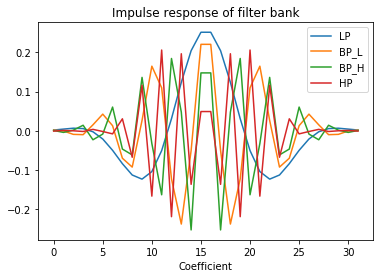

In [4]:
f1 = plt.figure()
for h in filterbank:
    plt.plot(h)
plt.legend(['LP','BP_L','BP_H','HP'])
plt.title('Impulse response of filter bank')
plt.xlabel('Coefficient')
plt.show()

Plot filter frequency responses:

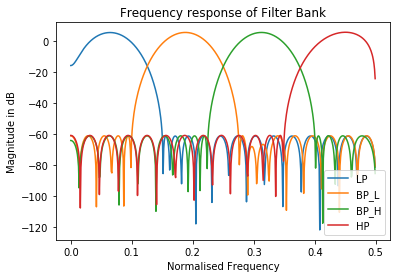

In [5]:
for h in filterbank:
    w,H = sig.freqz(h)
    # plot magnitude
    plt.plot(w/(np.pi*2),20*np.log10(np.abs(H)))
plt.legend(['LP','BP_L','BP_H','HP'])
plt.title('Frequency response of Filter Bank')
plt.xlabel('Normalised Frequency')
plt.ylabel('Magnitude in dB')
plt.show()

### Design filters using windowing

Definition of helper functions:
* sinc
* impulse response of ideal lowpass (sincInpulse)
* Cosine modulator 

In [210]:
def sinc(x):
    return (np.sin(x)/x)

def sincImpulse(N,wc):
    n = np.arange(0,N)
    delay = (N-1)/2.0
    # h = (wc/np.pi) * (np.sin(wc *(n-delay))/(np.pi*(n-delay)))
    h = (wc/np.pi)*sinc((n-delay)*wc)
    return h

def cosModulator(N,w0):
    n = np.arange(0,N)
    # delay = (N-1)/2.0
    # m = (1/np.pi)*np.cos(w0*np.pi*(n-delay))
    m = np.cos(w0*n)
    return m

Definitions of window functions:
* raised cosine window
* sin window

In [126]:
def raisedCosWinow(N):
    n = np.arange(0,N)
    if (N%2 == 0): # even
        c = 0.5-0.5*np.cos(2*np.pi/N*(n+0.5))
    else: # odd
        c = 0.5-0.5*np.cos(2*np.pi/(N+1)*(n+1))    
    return c

def sinWindow(N):
    n = np.arange(0,N)
    if (N%2 == 0): # even
        s = np.sin(np.pi/N*(n+0.5))
    else:
        s = np.sin(np.pi/(N+1)*(n+1))
    return s

Filterbank implementation:

In [244]:
def createFilterbank(nBands,nTabs):
    """Function to create a cosine modulated filterbank with nBands subbands and nTabs coefficients.
    It uses a raised cosine window function."""
    wLp = np.pi/(2*nBands)
    prototype = sincImpulse(nTabs, wLp) * raisedCosWinow(nTabs)
    fb = []
    for i in range(0,nBands):
        mod = cosModulator(nTabs, (2*i+1) * np.pi/(2*nBands))
        fb.append(2 * prototype * mod)
        
    return fb


In [242]:
FB = createFilterbank(4,104)

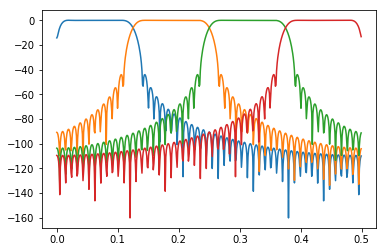

In [243]:
for h in FB:
    W,H = sig.freqz(h)
    plt.plot(w/(2*np.pi),20*np.log10(np.abs(H)))
plt.show()